In [127]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [128]:
def simulate_bivariate_abpnl(n: int) -> dict: 
    def f1(x: np.array) -> np.array:
        return x**(-1) + 10*x
    def f2(z: np.array) -> np.array:
        return z**3
    
    x = np.random.uniform(0.1, 1.1, n)
    noise = np.random.uniform(0, 5, n)
    
    z = f1(x) + noise
    y = f2(z)
    df = pd.DataFrame({'x1': x, 'x2': y})
    sim_data = {'df': df, 'noise': noise}
    
    return sim_data

In [129]:
def centering(M):
    n = M.shape[0]
    mat_ones = torch.ones((n, n))
    idendity = torch.eye(n)
    H = idendity - mat_ones/n
    
    C = torch.matmul(M, H)
    return C
    
    
def gaussian_grammat(x, sigma2=None):
    xxT = torch.squeeze(torch.matmul(x, x.T))
    x2 = torch.diag(xxT)
    xnorm = x2 - xxT + (x2 - xxT).T
    
    if sigma2 is None:
        sigma2 = torch.median(xnorm[xnorm != 0])
        
    if sigma2 == 0:
        sigma2 += 1e-16
        
    Kx = torch.exp(-xnorm/sigma2)
    
    return Kx
    
def HSIC(x, y):
    gram_x = gaussian_grammat(x)
    gram_y = gaussian_grammat(y)
    
    c = x.shape[0]**2
    hsic = torch.trace(torch.matmul(centering(gram_x), centering(gram_y)))/c
    
    return hsic

In [130]:
x = torch.Tensor(np.random.normal(size=1000).reshape((-1, 1, 1)))
y = torch.Tensor(np.random.normal(size=1000).reshape((-1, 1, 1)))
print(HSIC(x, y))
print(HSIC(x, x))

tensor(0.0003)
tensor(0.1004)


In [190]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        data = self.data[idx, :]
        
        return data[:-1].reshape((-1, 1)), data[-1].reshape((-1, 1))
    

class Network(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 5),
            nn.LeakyReLU(),
            nn.Linear(5, 5),
            nn.LeakyReLU(),
            nn.Linear(5, 5),
            nn.LeakyReLU(),
            nn.Linear(5, 5),
            nn.LeakyReLU(),
            nn.Linear(5, input_dim)
        )
        
        self.encode = nn.Sequential(
            nn.Linear(input_dim, 5),
            nn.LeakyReLU(),
            nn.Linear(5, 5),
            nn.LeakyReLU(),
            nn.Linear(5, 5),
            nn.LeakyReLU(),
            nn.Linear(5, 5),
            nn.LeakyReLU(),
            nn.Linear(5, input_dim)
        )
        self.decode = nn.Sequential(
            nn.Linear(input_dim, 5),
            nn.LeakyReLU(),
            nn.Linear(5, 5),
            nn.LeakyReLU(),
            nn.Linear(5, 5),
            nn.LeakyReLU(),
            nn.Linear(5, 5),
            nn.LeakyReLU(),
            nn.Linear(5, input_dim)
        )
        
    def forward(self, x, y):
        g1_x = self.network(x)
        g3_y = self.encode(y)
        y_approx = self.decode(g3_y)
        
        assert y.shape == y_approx.shape
        
        return [g1_x, y_approx, g3_y]
    
def train_model(num_epochs, log_every_batch = 10):
    device = 0 if torch.cuda.is_available() else 'cpu'
    model = Network(input_dim).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))

    train_loss_avgs = []
    test_loss_avgs = []
    
    min_loss = 10000

    for epoch in range(num_epochs):
        model.train()
        train_loss_trace = []

        for batch, (x, y) in enumerate(train_loader):
            x = x.to(device)
            x = x.float()
            y = y.to(device)
            y = y.float()

            g1_x, y_approx, g3_y = model.forward(x, y)
            noise = g3_y - g1_x

            loss = lamb*F.mse_loss(y_approx, y) + (1-lamb)*HSIC(x, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_trace.append(loss.detach().item())
            if batch % log_every_batch == 0:
                print(f'Training: epoch {epoch} batch {batch} loss {loss}')

        model.eval()
        test_loss_trace = []
        for batch, (x, y) in enumerate(test_loader):
            x = x.to(device)
            x = x.float()
            y = y.to(device)
            y = y.float()

            g1_x, y_approx, g3_y = model.forward(x, y)
            noise = g3_y - g1_x

            loss = lamb*F.mse_loss(y_approx, y) + (1-lamb)*HSIC(x, noise)

            test_loss_trace.append(loss.detach().item())
            if batch % log_every_batch == 0:
                print(f'Test: epoch {epoch} batch {batch} loss {loss}')

        train_avg = np.mean(train_loss_trace)
        test_avg = np.mean(test_loss_trace)
        
        if test_avg < min_loss:
            min_loss = test_avg

        train_loss_avgs.append(train_avg)
        test_loss_avgs.append(test_avg)
        print(f'epoch {epoch} finished - avarage train loss {train_avg} ',
             f'avarage test loss {test_avg}')
        
    return train_loss_avgs, test_loss_avgs, min_loss

In [191]:
n = 1000

batch_size = 32
lamb = 0.5
num_epochs = 200

num_trials = 9

In [173]:
data = simulate_bivariate_abpnl(n)
df = data['df']
noise = data['noise']

In [174]:
def get_final_min_loss(df, num_trials):
    input_dim = df.shape[1] - 1

    train, test = train_test_split(df, test_size=0.1, random_state=10, shuffle=True)

    train = np.array(train)
    test = np.array(test)

    train = MyDataset(train)
    test = MyDataset(test)
    
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, 
                              num_workers=0, pin_memory=True)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False,
                             num_workers=0, pin_memory=True)
    
    losses = []
    for trial in range(num_trials):
        train_loss_avgs, test_loss_avgs, min_loss = train_model(num_epochs)
        losses.append(min_loss)
    
    median_loss = np.median(losses)
    return median_loss, losses

In [175]:
# for b, (x, y) in enumerate(train_loader):
#     print(b)
#     print(x.shape)
#     print(y.shape)

In [176]:
median_loss, losses = get_final_min_loss(df, num_trials)

epoch 0 finished - avarage train loss 1502430.7543103448  avarage test loss 1082398.34375
epoch 1 finished - avarage train loss 476355.74132879847  avarage test loss 2681.979278564453
epoch 2 finished - avarage train loss 6380.504825723582  avarage test loss 1667.4767608642578
epoch 3 finished - avarage train loss 547.8154498790873  avarage test loss 11.309047222137451
epoch 4 finished - avarage train loss 31.922616547551648  avarage test loss 6.341284513473511
epoch 5 finished - avarage train loss 6.799437004944374  avarage test loss 6.250720977783203
epoch 6 finished - avarage train loss 6.495565743281923  avarage test loss 6.391325116157532
epoch 7 finished - avarage train loss 5.932754417945599  avarage test loss 7.756384491920471
epoch 8 finished - avarage train loss 6.008578127828137  avarage test loss 6.2679829597473145
epoch 9 finished - avarage train loss 5.839171532926889  avarage test loss 5.732759356498718
epoch 10 finished - avarage train loss 5.778265213144237  avarage te

epoch 88 finished - avarage train loss 1.2343417652722062  avarage test loss 0.26802073419094086
epoch 89 finished - avarage train loss 0.23340037799087063  avarage test loss 0.1864546425640583
epoch 90 finished - avarage train loss 0.20649711505092425  avarage test loss 0.11935469321906567
epoch 91 finished - avarage train loss 0.2821564245326766  avarage test loss 0.2055596075952053
epoch 92 finished - avarage train loss 0.17760011271156115  avarage test loss 0.10261113941669464
epoch 93 finished - avarage train loss 0.12438636118995733  avarage test loss 0.11067298240959644
epoch 94 finished - avarage train loss 0.19389227906177783  avarage test loss 0.9964061677455902
epoch 95 finished - avarage train loss 0.8130686444969013  avarage test loss 1.5394777357578278
epoch 96 finished - avarage train loss 0.35772920733895797  avarage test loss 0.4352770820260048
epoch 97 finished - avarage train loss 1.5828170730122204  avarage test loss 0.1035770233720541
epoch 98 finished - avarage tr

epoch 174 finished - avarage train loss 0.08865055801539586  avarage test loss 0.11721006222069263
epoch 175 finished - avarage train loss 0.08521375329843883  avarage test loss 0.1010851301252842
epoch 176 finished - avarage train loss 0.07005021631203849  avarage test loss 0.07158721052110195
epoch 177 finished - avarage train loss 0.06645920435930121  avarage test loss 0.07085084170103073
epoch 178 finished - avarage train loss 0.054204492604938044  avarage test loss 0.0638348525390029
epoch 179 finished - avarage train loss 0.07443749814711768  avarage test loss 0.05238964594900608
epoch 180 finished - avarage train loss 0.050288322542248104  avarage test loss 0.061827752739191055
epoch 181 finished - avarage train loss 0.05016139958953035  avarage test loss 0.09545116871595383
epoch 182 finished - avarage train loss 0.051027989400358034  avarage test loss 0.04457994922995567
epoch 183 finished - avarage train loss 0.045180920961088146  avarage test loss 0.08782695420086384
epoch 1

epoch 60 finished - avarage train loss 1.4427421483500251  avarage test loss 0.9755460172891617
epoch 61 finished - avarage train loss 1.3138313622310245  avarage test loss 0.9668550938367844
epoch 62 finished - avarage train loss 1.0146262630306442  avarage test loss 0.8989350944757462
epoch 63 finished - avarage train loss 1.023191053291847  avarage test loss 1.0794902294874191
epoch 64 finished - avarage train loss 0.957580768856509  avarage test loss 0.8841349333524704
epoch 65 finished - avarage train loss 0.9690248657917154  avarage test loss 0.8311527669429779
epoch 66 finished - avarage train loss 1.030489171373433  avarage test loss 0.6882505267858505
epoch 67 finished - avarage train loss 0.8116398279009194  avarage test loss 0.6911615431308746
epoch 68 finished - avarage train loss 0.8100912971743222  avarage test loss 1.7788731157779694
epoch 69 finished - avarage train loss 1.736195913676558  avarage test loss 0.5510539263486862
epoch 70 finished - avarage train loss 0.949

epoch 145 finished - avarage train loss 0.05365999852275026  avarage test loss 0.034616703167557716
epoch 146 finished - avarage train loss 0.02924048842798019  avarage test loss 0.0318309161812067
epoch 147 finished - avarage train loss 0.031549817015384805  avarage test loss 0.05979847442358732
epoch 148 finished - avarage train loss 0.06013870753090957  avarage test loss 0.06605381611734629
epoch 149 finished - avarage train loss 0.04715592292105329  avarage test loss 0.05065467208623886
epoch 150 finished - avarage train loss 0.04533119557489609  avarage test loss 0.02634853171184659
epoch 151 finished - avarage train loss 0.029170955081695114  avarage test loss 0.040249972604215145
epoch 152 finished - avarage train loss 0.0214208228320911  avarage test loss 0.023088466841727495
epoch 153 finished - avarage train loss 0.029160431650435102  avarage test loss 0.048364599235355854
epoch 154 finished - avarage train loss 0.023373143779563493  avarage test loss 0.024828125722706318
epo

epoch 30 finished - avarage train loss 1.4895990675893322  avarage test loss 1.4885464310646057
epoch 31 finished - avarage train loss 1.6219848024434056  avarage test loss 2.1034190952777863
epoch 32 finished - avarage train loss 1.7505879319947342  avarage test loss 1.4871336221694946
epoch 33 finished - avarage train loss 1.7616375355884946  avarage test loss 2.525930166244507
epoch 34 finished - avarage train loss 1.4762580148104965  avarage test loss 1.4989236295223236
epoch 35 finished - avarage train loss 1.3704493621300007  avarage test loss 1.585406094789505
epoch 36 finished - avarage train loss 1.3885265979273567  avarage test loss 1.3863465785980225
epoch 37 finished - avarage train loss 1.5456762108309516  avarage test loss 2.141144335269928
epoch 38 finished - avarage train loss 1.4874130631315297  avarage test loss 1.975688397884369
epoch 39 finished - avarage train loss 1.5969499863427261  avarage test loss 1.3442587852478027
epoch 40 finished - avarage train loss 1.785

epoch 116 finished - avarage train loss 0.21075305368365913  avarage test loss 0.20835048332810402
epoch 117 finished - avarage train loss 0.702454436570406  avarage test loss 0.7717669308185577
epoch 118 finished - avarage train loss 0.2118496996318472  avarage test loss 0.06762104481458664
epoch 119 finished - avarage train loss 0.07832650596211696  avarage test loss 0.04544123914092779
epoch 120 finished - avarage train loss 0.04815824972144488  avarage test loss 0.09362076036632061
epoch 121 finished - avarage train loss 1.3925870859931255  avarage test loss 0.04290823498740792
epoch 122 finished - avarage train loss 2.3111378387387456  avarage test loss 2.022238403558731
epoch 123 finished - avarage train loss 4.77724659789739  avarage test loss 25.22364830970764
epoch 124 finished - avarage train loss 95.16567966085056  avarage test loss 104.68380355834961
epoch 125 finished - avarage train loss 519.828727783571  avarage test loss 599.0987701416016
epoch 126 finished - avarage tr

epoch 0 finished - avarage train loss 1492607.8469827587  avarage test loss 1134671.4375
epoch 1 finished - avarage train loss 1222171.9775222251  avarage test loss 148337.353515625
epoch 2 finished - avarage train loss 67449.80326974802  avarage test loss 11369.066528320312
epoch 3 finished - avarage train loss 3361.8193697764955  avarage test loss 189.84353065490723
epoch 4 finished - avarage train loss 277.1228791269763  avarage test loss 31.366490364074707
epoch 5 finished - avarage train loss 21.134738198642072  avarage test loss 8.792826890945435
epoch 6 finished - avarage train loss 8.913289958033069  avarage test loss 8.291580200195312
epoch 7 finished - avarage train loss 8.874957660148883  avarage test loss 7.843323349952698
epoch 8 finished - avarage train loss 8.932358363579059  avarage test loss 8.777894854545593
epoch 9 finished - avarage train loss 7.637168292341562  avarage test loss 7.6128950119018555
epoch 10 finished - avarage train loss 7.6331939697265625  avarage t

epoch 88 finished - avarage train loss 0.39409087752473765  avarage test loss 0.25886474177241325
epoch 89 finished - avarage train loss 0.26931147277355194  avarage test loss 0.23479121923446655
epoch 90 finished - avarage train loss 0.3591030574050443  avarage test loss 0.6425482332706451
epoch 91 finished - avarage train loss 1.4035039045687379  avarage test loss 2.292806476354599
epoch 92 finished - avarage train loss 1.0964935010877148  avarage test loss 0.6498279422521591
epoch 93 finished - avarage train loss 0.34480803588341025  avarage test loss 0.18126963824033737
epoch 94 finished - avarage train loss 0.23505150449687037  avarage test loss 0.2555053271353245
epoch 95 finished - avarage train loss 0.17803351606788306  avarage test loss 0.7344333827495575
epoch 96 finished - avarage train loss 0.3475991615961338  avarage test loss 0.7185017839074135
epoch 97 finished - avarage train loss 0.35094391785818957  avarage test loss 0.15264137275516987
epoch 98 finished - avarage tra

epoch 173 finished - avarage train loss 0.02334434391352637  avarage test loss 0.032233902253210545
epoch 174 finished - avarage train loss 0.023749005434841944  avarage test loss 0.03218257473781705
epoch 175 finished - avarage train loss 0.02328243100180708  avarage test loss 0.03221253352239728
epoch 176 finished - avarage train loss 0.023705302127476395  avarage test loss 0.03218597965314984
epoch 177 finished - avarage train loss 0.022539823155464798  avarage test loss 0.03218149300664663
epoch 178 finished - avarage train loss 0.02366816576827189  avarage test loss 0.03314495738595724
epoch 179 finished - avarage train loss 0.023134442913378107  avarage test loss 0.03210703656077385
epoch 180 finished - avarage train loss 0.024573415260890435  avarage test loss 0.03208534140139818
epoch 181 finished - avarage train loss 0.023328776920920814  avarage test loss 0.03210386261343956
epoch 182 finished - avarage train loss 0.024202417132669483  avarage test loss 0.03219956997781992
ep

epoch 59 finished - avarage train loss 1.335803245675975  avarage test loss 1.163802683353424
epoch 60 finished - avarage train loss 1.206563949584961  avarage test loss 0.9964779913425446
epoch 61 finished - avarage train loss 0.9616388740210697  avarage test loss 0.8973361402750015
epoch 62 finished - avarage train loss 1.0514173887926956  avarage test loss 0.9048905372619629
epoch 63 finished - avarage train loss 0.7396519410199133  avarage test loss 0.6444367468357086
epoch 64 finished - avarage train loss 0.62920998293778  avarage test loss 0.5275127664208412
epoch 65 finished - avarage train loss 0.5034571536656084  avarage test loss 0.6846906393766403
epoch 66 finished - avarage train loss 0.4782417704319132  avarage test loss 0.38623955100774765
epoch 67 finished - avarage train loss 0.4185460307474794  avarage test loss 0.3306465744972229
epoch 68 finished - avarage train loss 0.30721527338027954  avarage test loss 0.3752702847123146
epoch 69 finished - avarage train loss 0.30

epoch 143 finished - avarage train loss 0.008583296483767957  avarage test loss 0.014197110431268811
epoch 144 finished - avarage train loss 0.00899103136155112  avarage test loss 0.01357273303437978
epoch 145 finished - avarage train loss 0.008964712145449272  avarage test loss 0.012827665894292295
epoch 146 finished - avarage train loss 0.01222214016035713  avarage test loss 0.014130633790045977
epoch 147 finished - avarage train loss 0.024882864303373057  avarage test loss 0.09168282896280289
epoch 148 finished - avarage train loss 0.04383233263446339  avarage test loss 0.02146379230543971
epoch 149 finished - avarage train loss 0.019398313288673245  avarage test loss 0.013528543058782816
epoch 150 finished - avarage train loss 0.01217446844735793  avarage test loss 0.014976093196310103
epoch 151 finished - avarage train loss 0.1266518554586018  avarage test loss 0.0992868710309267
epoch 152 finished - avarage train loss 10.903827367800064  avarage test loss 1640.4747924804688
epoch

epoch 30 finished - avarage train loss 5.554564558226486  avarage test loss 5.004892826080322
epoch 31 finished - avarage train loss 5.270053222261626  avarage test loss 5.88691258430481
epoch 32 finished - avarage train loss 5.479809539071445  avarage test loss 6.277340590953827
epoch 33 finished - avarage train loss 5.3240195636091565  avarage test loss 6.8095924854278564
epoch 34 finished - avarage train loss 5.4531887564165835  avarage test loss 5.314409494400024
epoch 35 finished - avarage train loss 4.684080049909395  avarage test loss 4.146274149417877
epoch 36 finished - avarage train loss 4.162852213300508  avarage test loss 3.931434154510498
epoch 37 finished - avarage train loss 4.383478411312761  avarage test loss 7.462605714797974
epoch 38 finished - avarage train loss 4.6564830459397415  avarage test loss 3.744798481464386
epoch 39 finished - avarage train loss 3.899413988508027  avarage test loss 4.607312917709351
epoch 40 finished - avarage train loss 3.7196372706314613

epoch 117 finished - avarage train loss 0.11643399240384841  avarage test loss 0.049958704970777035
epoch 118 finished - avarage train loss 0.05100436714188806  avarage test loss 0.16263224184513092
epoch 119 finished - avarage train loss 0.11142444706939418  avarage test loss 0.022463877452537417
epoch 120 finished - avarage train loss 0.02594243924550969  avarage test loss 0.01970637566410005
epoch 121 finished - avarage train loss 0.016500180073339362  avarage test loss 0.029217731207609177
epoch 122 finished - avarage train loss 0.10019867260265967  avarage test loss 0.06324044615030289
epoch 123 finished - avarage train loss 0.018848453905304957  avarage test loss 0.022036541253328323
epoch 124 finished - avarage train loss 0.017379008378062784  avarage test loss 0.02010255795903504
epoch 125 finished - avarage train loss 0.03510227881307746  avarage test loss 0.15228294767439365
epoch 126 finished - avarage train loss 0.35784043724937686  avarage test loss 0.2212851531803608
epoc

epoch 3 finished - avarage train loss 1611.7912450658864  avarage test loss 57.10553550720215
epoch 4 finished - avarage train loss 76.4529868487654  avarage test loss 27.017428398132324
epoch 5 finished - avarage train loss 9.026633681922123  avarage test loss 5.312554836273193
epoch 6 finished - avarage train loss 4.775880714942669  avarage test loss 4.781893610954285
epoch 7 finished - avarage train loss 4.503934325843022  avarage test loss 4.649371981620789
epoch 8 finished - avarage train loss 4.568625507683589  avarage test loss 4.872969627380371
epoch 9 finished - avarage train loss 4.457170165818313  avarage test loss 4.67980420589447
epoch 10 finished - avarage train loss 4.6994730604105985  avarage test loss 4.600013256072998
epoch 11 finished - avarage train loss 4.664589939446285  avarage test loss 5.235926389694214
epoch 12 finished - avarage train loss 4.332355795235469  avarage test loss 4.610154926776886
epoch 13 finished - avarage train loss 4.285983077410994  avarage 

epoch 90 finished - avarage train loss 0.4401174711770025  avarage test loss 0.3638304993510246
epoch 91 finished - avarage train loss 0.43546145537803915  avarage test loss 1.3238516747951508
epoch 92 finished - avarage train loss 0.6484425329956515  avarage test loss 0.3409260883927345
epoch 93 finished - avarage train loss 0.45694791448527367  avarage test loss 0.41517848521471024
epoch 94 finished - avarage train loss 0.3022310086365404  avarage test loss 0.5649115964770317
epoch 95 finished - avarage train loss 0.3085082558722332  avarage test loss 0.8818709403276443
epoch 96 finished - avarage train loss 0.6513734259482088  avarage test loss 0.20470963045954704
epoch 97 finished - avarage train loss 0.24573317966584501  avarage test loss 0.1921180561184883
epoch 98 finished - avarage train loss 0.19139057243692464  avarage test loss 0.18327360227704048
epoch 99 finished - avarage train loss 0.20866456602154107  avarage test loss 0.16122125834226608
epoch 100 finished - avarage tr

epoch 174 finished - avarage train loss 0.03484888972136481  avarage test loss 0.040602932684123516
epoch 175 finished - avarage train loss 0.0701764363410144  avarage test loss 0.032143857795745134
epoch 176 finished - avarage train loss 0.030503243079473233  avarage test loss 0.03600546810775995
epoch 177 finished - avarage train loss 0.04756897045620557  avarage test loss 0.035995252430438995
epoch 178 finished - avarage train loss 0.025212299335619498  avarage test loss 0.09464436024427414
epoch 179 finished - avarage train loss 0.031222568792772704  avarage test loss 0.020007172832265496
epoch 180 finished - avarage train loss 0.02714443810541054  avarage test loss 0.02249633288010955
epoch 181 finished - avarage train loss 0.027667577956514113  avarage test loss 0.027245301753282547
epoch 182 finished - avarage train loss 0.01938055409118533  avarage test loss 0.02245516492985189
epoch 183 finished - avarage train loss 0.024753506841330694  avarage test loss 0.02441519685089588
e

epoch 61 finished - avarage train loss 0.6842663596416342  avarage test loss 0.9175494313240051
epoch 62 finished - avarage train loss 0.6397479736599428  avarage test loss 0.5982208102941513
epoch 63 finished - avarage train loss 0.5397527721421472  avarage test loss 0.49499158561229706
epoch 64 finished - avarage train loss 0.4972687651371134  avarage test loss 0.4528941586613655
epoch 65 finished - avarage train loss 0.5388829533396096  avarage test loss 0.407800555229187
epoch 66 finished - avarage train loss 0.43558484110338935  avarage test loss 0.3733689785003662
epoch 67 finished - avarage train loss 0.3818057395260909  avarage test loss 0.33402498811483383
epoch 68 finished - avarage train loss 0.5308715860391485  avarage test loss 0.37664563208818436
epoch 69 finished - avarage train loss 0.31687682044917137  avarage test loss 0.27239202335476875
epoch 70 finished - avarage train loss 0.25761142527234965  avarage test loss 0.39321403205394745
epoch 71 finished - avarage train

epoch 145 finished - avarage train loss 0.007910237768022665  avarage test loss 0.013213247410021722
epoch 146 finished - avarage train loss 0.008813602504609474  avarage test loss 0.012583108444232494
epoch 147 finished - avarage train loss 0.007567407218097099  avarage test loss 0.012522972945589572
epoch 148 finished - avarage train loss 0.007982939895210338  avarage test loss 0.014073486672714353
epoch 149 finished - avarage train loss 0.008558551877223212  avarage test loss 0.014440798433497548
epoch 150 finished - avarage train loss 0.009161895269463802  avarage test loss 0.012999922153539956
epoch 151 finished - avarage train loss 0.008093121477627549  avarage test loss 0.01384256244637072
epoch 152 finished - avarage train loss 0.00886006813881726  avarage test loss 0.013772947480902076
epoch 153 finished - avarage train loss 0.011586383081458766  avarage test loss 0.014665001188404858
epoch 154 finished - avarage train loss 0.1672631712180787  avarage test loss 1.9315882623195

epoch 30 finished - avarage train loss 24.796205816597773  avarage test loss 23.81606912612915
epoch 31 finished - avarage train loss 24.698029551012763  avarage test loss 21.3813738822937
epoch 32 finished - avarage train loss 21.461763579269935  avarage test loss 22.79145336151123
epoch 33 finished - avarage train loss 19.941607508166083  avarage test loss 28.70122241973877
epoch 34 finished - avarage train loss 19.019183619269008  avarage test loss 18.24372673034668
epoch 35 finished - avarage train loss 15.198315620422363  avarage test loss 19.088164806365967
epoch 36 finished - avarage train loss 16.691441174211175  avarage test loss 13.281525373458862
epoch 37 finished - avarage train loss 16.28547737516206  avarage test loss 16.13512420654297
epoch 38 finished - avarage train loss 16.843789889894683  avarage test loss 32.6729416847229
epoch 39 finished - avarage train loss 22.377796732146166  avarage test loss 21.661783933639526
epoch 40 finished - avarage train loss 16.56204190

epoch 116 finished - avarage train loss 0.009335471325200694  avarage test loss 0.013113332563079894
epoch 117 finished - avarage train loss 0.00975496056971365  avarage test loss 0.014143304782919586
epoch 118 finished - avarage train loss 0.010043557299750632  avarage test loss 0.013648430700413883
epoch 119 finished - avarage train loss 0.009291556430980563  avarage test loss 0.01312947750557214
epoch 120 finished - avarage train loss 0.007529920376516108  avarage test loss 0.013152043800801039
epoch 121 finished - avarage train loss 0.007889575220580244  avarage test loss 0.014161387109197676
epoch 122 finished - avarage train loss 0.008653605983046622  avarage test loss 0.013017253950238228
epoch 123 finished - avarage train loss 0.0098309227233303  avarage test loss 0.013146545621566474
epoch 124 finished - avarage train loss 0.008472808853498307  avarage test loss 0.014001415809616446
epoch 125 finished - avarage train loss 0.008152196047313768  avarage test loss 0.0147461926098

In [177]:
median_loss

0.013170736958272755

In [178]:
losses

[0.016273024026304483,
 0.012907609925605357,
 0.014330125995911658,
 0.03202114952728152,
 0.0123107407707721,
 0.013170736958272755,
 0.01329420949332416,
 0.010295620595570654,
 0.012752796930726618]

In [181]:
df[['x2', 'x1']].head()

,x2,x1
0,628.434212,0.226737
1,946.754022,0.187158
2,1026.585374,0.418154
3,2893.236877,0.883826
4,380.284502,0.443577


In [182]:
median_loss_back, losses_back = get_final_min_loss(df[['x2', 'x1']], num_trials)

epoch 0 finished - avarage train loss 1488001.7219827587  avarage test loss 1133786.1875
epoch 1 finished - avarage train loss 1173779.0092605064  avarage test loss 258585.4296875
epoch 2 finished - avarage train loss 65716.76031073209  avarage test loss 19963.019287109375
epoch 3 finished - avarage train loss 5083.385254432415  avarage test loss 1379.9308166503906
epoch 4 finished - avarage train loss 399.53443172060213  avarage test loss 150.50488662719727
epoch 5 finished - avarage train loss 145.34800799139614  avarage test loss 143.9319248199463
epoch 6 finished - avarage train loss 140.48968111235519  avarage test loss 148.78741073608398
epoch 7 finished - avarage train loss 147.417236328125  avarage test loss 173.9281463623047
epoch 8 finished - avarage train loss 181.13100696432178  avarage test loss 136.45640182495117
epoch 9 finished - avarage train loss 129.2750683488517  avarage test loss 125.46357917785645
epoch 10 finished - avarage train loss 119.59103525095972  avarage 

epoch 88 finished - avarage train loss 0.02428884951975839  avarage test loss 0.02506427513435483
epoch 89 finished - avarage train loss 0.02688443307475797  avarage test loss 0.05295530054718256
epoch 90 finished - avarage train loss 0.02656606401734311  avarage test loss 0.025843961630016565
epoch 91 finished - avarage train loss 0.01967806590656782  avarage test loss 0.048676591366529465
epoch 92 finished - avarage train loss 0.018444954321302217  avarage test loss 0.018536641728132963
epoch 93 finished - avarage train loss 0.01703746008269232  avarage test loss 0.02124755410477519
epoch 94 finished - avarage train loss 0.017557215748419022  avarage test loss 0.017914237454533577
epoch 95 finished - avarage train loss 0.013351840769936299  avarage test loss 0.01634317508433014
epoch 96 finished - avarage train loss 0.013080881587390241  avarage test loss 0.015842503285966814
epoch 97 finished - avarage train loss 0.011583765342446237  avarage test loss 0.017147646052762866
epoch 98 

epoch 171 finished - avarage train loss 0.010721084982927504  avarage test loss 0.01408618944697082
epoch 172 finished - avarage train loss 0.010370861610461926  avarage test loss 0.014109671232290566
epoch 173 finished - avarage train loss 0.009289352383849949  avarage test loss 0.01441406027879566
epoch 174 finished - avarage train loss 0.011878799430319461  avarage test loss 0.014093199628405273
epoch 175 finished - avarage train loss 0.00946334857044035  avarage test loss 0.014084227266721427
epoch 176 finished - avarage train loss 0.010151431703105056  avarage test loss 0.014026033226400614
epoch 177 finished - avarage train loss 0.011437673964698252  avarage test loss 0.014199115568771958
epoch 178 finished - avarage train loss 0.010801444986257059  avarage test loss 0.014094531768932939
epoch 179 finished - avarage train loss 0.010198283731808951  avarage test loss 0.014916133251972497
epoch 180 finished - avarage train loss 0.028144113318031204  avarage test loss 0.035074319690

epoch 59 finished - avarage train loss 1.217324030810389  avarage test loss 2.5598249435424805
epoch 60 finished - avarage train loss 1.9328720096884102  avarage test loss 3.079677164554596
epoch 61 finished - avarage train loss 1.4376059544497524  avarage test loss 1.469334915280342
epoch 62 finished - avarage train loss 1.5056110497178703  avarage test loss 1.7136810421943665
epoch 63 finished - avarage train loss 1.618208227486446  avarage test loss 0.9905964583158493
epoch 64 finished - avarage train loss 1.5022364546512734  avarage test loss 1.2007998526096344
epoch 65 finished - avarage train loss 0.9708148179383114  avarage test loss 0.9760917127132416
epoch 66 finished - avarage train loss 1.0003553752241463  avarage test loss 1.09782475233078
epoch 67 finished - avarage train loss 0.832020238555711  avarage test loss 0.9229527413845062
epoch 68 finished - avarage train loss 0.8297176340530659  avarage test loss 0.737293466925621
epoch 69 finished - avarage train loss 0.8340636

epoch 144 finished - avarage train loss 603.0515093967832  avarage test loss 450.5899963378906
epoch 145 finished - avarage train loss 120.67485834349846  avarage test loss 3.369312882423401
epoch 146 finished - avarage train loss 3.789500347242273  avarage test loss 0.5192575678229332
epoch 147 finished - avarage train loss 0.18608786422630835  avarage test loss 0.13630574569106102
epoch 148 finished - avarage train loss 0.16556428732543155  avarage test loss 0.2653215043246746
epoch 149 finished - avarage train loss 0.24136583314373575  avarage test loss 0.10861365497112274
epoch 150 finished - avarage train loss 0.19296079347359724  avarage test loss 0.24486799538135529
epoch 151 finished - avarage train loss 0.2943577532624376  avarage test loss 0.18199248611927032
epoch 152 finished - avarage train loss 0.09445298720022728  avarage test loss 0.06639435701072216
epoch 153 finished - avarage train loss 0.08126503961353466  avarage test loss 0.13829617202281952
epoch 154 finished - a

epoch 29 finished - avarage train loss 4.932019028170355  avarage test loss 4.588884949684143
epoch 30 finished - avarage train loss 4.609433124805319  avarage test loss 4.427853763103485
epoch 31 finished - avarage train loss 4.579907047337499  avarage test loss 4.324248313903809
epoch 32 finished - avarage train loss 4.3191122926514725  avarage test loss 6.9190895557403564
epoch 33 finished - avarage train loss 5.1351527181164975  avarage test loss 4.120052695274353
epoch 34 finished - avarage train loss 4.735072744303737  avarage test loss 9.78069519996643
epoch 35 finished - avarage train loss 5.908402188070889  avarage test loss 4.277222573757172
epoch 36 finished - avarage train loss 4.104861218353798  avarage test loss 3.840870201587677
epoch 37 finished - avarage train loss 4.404606786267511  avarage test loss 4.987873673439026
epoch 38 finished - avarage train loss 4.250426103328836  avarage test loss 4.2587268352508545
epoch 39 finished - avarage train loss 3.515439880305323 

epoch 116 finished - avarage train loss 0.06526568442069251  avarage test loss 0.09953444451093674
epoch 117 finished - avarage train loss 0.09507935776792724  avarage test loss 0.09383225068449974
epoch 118 finished - avarage train loss 0.12037794902149973  avarage test loss 0.12320255488157272
epoch 119 finished - avarage train loss 0.05625995807349682  avarage test loss 0.04749711882323027
epoch 120 finished - avarage train loss 0.045822427704416475  avarage test loss 0.03512294450774789
epoch 121 finished - avarage train loss 0.03169606227813096  avarage test loss 0.02939122822135687
epoch 122 finished - avarage train loss 0.03608594243896419  avarage test loss 0.03837040439248085
epoch 123 finished - avarage train loss 0.03665139789468255  avarage test loss 0.028679808136075735
epoch 124 finished - avarage train loss 0.036764151705750106  avarage test loss 0.03496423922479153
epoch 125 finished - avarage train loss 0.029354933777759815  avarage test loss 0.026448574848473072
epoch

epoch 199 finished - avarage train loss 0.010335040326904634  avarage test loss 0.013309594010934234
epoch 0 finished - avarage train loss 1225022.4725215517  avarage test loss 12398.68212890625
epoch 1 finished - avarage train loss 53137.443476446744  avarage test loss 68.10223960876465
epoch 2 finished - avarage train loss 3411.3718931263893  avarage test loss 320.0244331359863
epoch 3 finished - avarage train loss 253.90552249448052  avarage test loss 47.23188781738281
epoch 4 finished - avarage train loss 17.709145940583326  avarage test loss 6.502549529075623
epoch 5 finished - avarage train loss 6.064005654433678  avarage test loss 5.671151518821716
epoch 6 finished - avarage train loss 5.394541411564268  avarage test loss 5.4338648319244385
epoch 7 finished - avarage train loss 5.722088123189992  avarage test loss 5.345003962516785
epoch 8 finished - avarage train loss 5.371817942323355  avarage test loss 5.3492653369903564
epoch 9 finished - avarage train loss 5.266044707133852

epoch 85 finished - avarage train loss 0.07977561357206311  avarage test loss 0.07358220499008894
epoch 86 finished - avarage train loss 0.07543449386440475  avarage test loss 0.15885279700160027
epoch 87 finished - avarage train loss 0.08467059865080077  avarage test loss 0.07437083497643471
epoch 88 finished - avarage train loss 0.0832948134890918  avarage test loss 0.18974871560931206
epoch 89 finished - avarage train loss 0.11877608607555258  avarage test loss 0.06490020081400871
epoch 90 finished - avarage train loss 0.12329069049707775  avarage test loss 0.09338026493787766
epoch 91 finished - avarage train loss 0.060250553334581444  avarage test loss 0.04289782699197531
epoch 92 finished - avarage train loss 0.04919660804343635  avarage test loss 0.06970277801156044
epoch 93 finished - avarage train loss 0.04206150436195834  avarage test loss 0.03956116968765855
epoch 94 finished - avarage train loss 0.033845505195445026  avarage test loss 0.034142124466598034
epoch 95 finished 

epoch 171 finished - avarage train loss 8.511668785635766  avarage test loss 10.543619632720947
epoch 172 finished - avarage train loss 7.9797103446105435  avarage test loss 16.865832090377808
epoch 173 finished - avarage train loss 131.80858064314415  avarage test loss 1752.4674377441406
epoch 174 finished - avarage train loss 1475.6219788255362  avarage test loss 13.828428745269775
epoch 175 finished - avarage train loss 477.5385929265156  avarage test loss 1279.5933685302734
epoch 176 finished - avarage train loss 432.3063540993066  avarage test loss 243.7352294921875
epoch 177 finished - avarage train loss 447.7388080913445  avarage test loss 38.12736701965332
epoch 178 finished - avarage train loss 109.60842908687633  avarage test loss 2.1732157170772552
epoch 179 finished - avarage train loss 18.808934394655555  avarage test loss 7.525618553161621
epoch 180 finished - avarage train loss 6.25651776931923  avarage test loss 58.65669536590576
epoch 181 finished - avarage train loss 

epoch 57 finished - avarage train loss 0.8423854400371683  avarage test loss 0.9646651595830917
epoch 58 finished - avarage train loss 0.932351486436252  avarage test loss 1.1750375777482986
epoch 59 finished - avarage train loss 0.9301534192315464  avarage test loss 0.7996608018875122
epoch 60 finished - avarage train loss 0.8117202808117044  avarage test loss 1.22952800989151
epoch 61 finished - avarage train loss 0.79000333979212  avarage test loss 0.7304671108722687
epoch 62 finished - avarage train loss 0.889546577272744  avarage test loss 0.7128334045410156
epoch 63 finished - avarage train loss 0.7145376061571056  avarage test loss 0.7725710421800613
epoch 64 finished - avarage train loss 0.8196926836309761  avarage test loss 0.713270366191864
epoch 65 finished - avarage train loss 0.8783729939625181  avarage test loss 0.731860414147377
epoch 66 finished - avarage train loss 0.7518335693869097  avarage test loss 1.1596348285675049
epoch 67 finished - avarage train loss 0.7546621

epoch 142 finished - avarage train loss 165.6946721940205  avarage test loss 3124.129669189453
epoch 143 finished - avarage train loss 3530.852704194085  avarage test loss 428.1570053100586
epoch 144 finished - avarage train loss 133.69713260464627  avarage test loss 62.0571985244751
epoch 145 finished - avarage train loss 106.48546610207393  avarage test loss 98.56123065948486
epoch 146 finished - avarage train loss 59.24284241965105  avarage test loss 2.129638820886612
epoch 147 finished - avarage train loss 0.32451020784932993  avarage test loss 0.029741358011960983
epoch 148 finished - avarage train loss 0.028499849140644073  avarage test loss 0.04613166209310293
epoch 149 finished - avarage train loss 0.06148494924579201  avarage test loss 0.09563272632658482
epoch 150 finished - avarage train loss 0.05081536803908389  avarage test loss 0.02946343319490552
epoch 151 finished - avarage train loss 0.026506637512096042  avarage test loss 0.024646053090691566
epoch 152 finished - avar

epoch 29 finished - avarage train loss 2.0558760906087943  avarage test loss 2.0134841799736023
epoch 30 finished - avarage train loss 2.316735033331246  avarage test loss 1.973407357931137
epoch 31 finished - avarage train loss 1.9644984130201668  avarage test loss 2.183147579431534
epoch 32 finished - avarage train loss 1.8918940229662533  avarage test loss 2.3885586857795715
epoch 33 finished - avarage train loss 1.930961041614927  avarage test loss 1.8852570354938507
epoch 34 finished - avarage train loss 1.8819164983157455  avarage test loss 1.9112539887428284
epoch 35 finished - avarage train loss 1.8691856984434456  avarage test loss 1.8391114175319672
epoch 36 finished - avarage train loss 1.9493184952900326  avarage test loss 1.8296459913253784
epoch 37 finished - avarage train loss 1.8445154284608776  avarage test loss 1.8077106475830078
epoch 38 finished - avarage train loss 1.7403203721704155  avarage test loss 1.8169434070587158
epoch 39 finished - avarage train loss 1.798

epoch 115 finished - avarage train loss 0.39619309840531186  avarage test loss 0.648639090359211
epoch 116 finished - avarage train loss 0.8909695991154375  avarage test loss 4.2576406598091125
epoch 117 finished - avarage train loss 1.0492225320174777  avarage test loss 0.2889523133635521
epoch 118 finished - avarage train loss 0.3064137024098429  avarage test loss 0.19312112778425217
epoch 119 finished - avarage train loss 0.6945143293203979  avarage test loss 0.8638470321893692
epoch 120 finished - avarage train loss 0.47404628658089143  avarage test loss 0.4787479415535927
epoch 121 finished - avarage train loss 0.3449240147039808  avarage test loss 0.20649108290672302
epoch 122 finished - avarage train loss 0.2770606240835683  avarage test loss 0.2008734978735447
epoch 123 finished - avarage train loss 0.3597792497482793  avarage test loss 0.2142602987587452
epoch 124 finished - avarage train loss 0.2826194901918543  avarage test loss 0.15688461437821388
epoch 125 finished - avara

epoch 0 finished - avarage train loss 1454620.9439655172  avarage test loss 1021985.140625
epoch 1 finished - avarage train loss 316040.04698990134  avarage test loss 34578.20751953125
epoch 2 finished - avarage train loss 11767.164355837065  avarage test loss 1897.6602478027344
epoch 3 finished - avarage train loss 543.982119593127  avarage test loss 16.895609855651855
epoch 4 finished - avarage train loss 29.744925959356898  avarage test loss 11.7283775806427
epoch 5 finished - avarage train loss 11.118092882222143  avarage test loss 11.039382219314575
epoch 6 finished - avarage train loss 11.235226960017764  avarage test loss 12.843413829803467
epoch 7 finished - avarage train loss 11.73841825024835  avarage test loss 11.935146570205688
epoch 8 finished - avarage train loss 10.156220773170734  avarage test loss 11.008829832077026
epoch 9 finished - avarage train loss 10.703971550382416  avarage test loss 12.17699384689331
epoch 10 finished - avarage train loss 10.911935395207898  av

epoch 88 finished - avarage train loss 0.09155056278767257  avarage test loss 0.0652098162099719
epoch 89 finished - avarage train loss 0.061249322290050576  avarage test loss 0.07390687242150307
epoch 90 finished - avarage train loss 0.08782533761756174  avarage test loss 0.22312988713383675
epoch 91 finished - avarage train loss 0.12769956976689142  avarage test loss 0.052855635061860085
epoch 92 finished - avarage train loss 0.058828928668437336  avarage test loss 0.03988181846216321
epoch 93 finished - avarage train loss 0.07668609634555619  avarage test loss 0.09671750105917454
epoch 94 finished - avarage train loss 0.04487561980455086  avarage test loss 0.06642256490886211
epoch 95 finished - avarage train loss 0.07000998523214767  avarage test loss 0.030657861847430468
epoch 96 finished - avarage train loss 0.03249074464085801  avarage test loss 0.04618894401937723
epoch 97 finished - avarage train loss 0.07395791320194459  avarage test loss 0.12492794916033745
epoch 98 finished

epoch 173 finished - avarage train loss 1.08717456691224  avarage test loss 7.31438410282135
epoch 174 finished - avarage train loss 1.3139638359947452  avarage test loss 0.23984209820628166
epoch 175 finished - avarage train loss 2.3868846245880784  avarage test loss 11.688207864761353
epoch 176 finished - avarage train loss 5.604875916101295  avarage test loss 10.039266705513
epoch 177 finished - avarage train loss 21.983995451495566  avarage test loss 59.797319412231445
epoch 178 finished - avarage train loss 9.07945434402289  avarage test loss 0.10222718864679337
epoch 179 finished - avarage train loss 0.8257207523003735  avarage test loss 0.45663298666477203
epoch 180 finished - avarage train loss 0.3006893947463611  avarage test loss 0.34338880330324173
epoch 181 finished - avarage train loss 0.15705817257022037  avarage test loss 0.018977567553520203
epoch 182 finished - avarage train loss 0.01745682036311462  avarage test loss 0.028201472014188766
epoch 183 finished - avarage t

epoch 61 finished - avarage train loss 0.7966135781386803  avarage test loss 0.9975476711988449
epoch 62 finished - avarage train loss 0.9457481174633421  avarage test loss 0.6802138537168503
epoch 63 finished - avarage train loss 0.6844857602283873  avarage test loss 0.8955626785755157
epoch 64 finished - avarage train loss 0.6372437785411703  avarage test loss 0.7316636443138123
epoch 65 finished - avarage train loss 0.6650092529839483  avarage test loss 1.0204700827598572
epoch 66 finished - avarage train loss 0.8832468801531298  avarage test loss 0.5978137776255608
epoch 67 finished - avarage train loss 0.6540067576128861  avarage test loss 1.182897686958313
epoch 68 finished - avarage train loss 0.8588147559042635  avarage test loss 0.5402206033468246
epoch 69 finished - avarage train loss 0.5771070852361876  avarage test loss 0.5459918081760406
epoch 70 finished - avarage train loss 0.5683868856265627  avarage test loss 0.8095376193523407
epoch 71 finished - avarage train loss 0.

epoch 148 finished - avarage train loss 0.03971335722197746  avarage test loss 0.029461574740707874
epoch 149 finished - avarage train loss 0.020477410694905395  avarage test loss 0.022235081531107426
epoch 150 finished - avarage train loss 0.019100412308912854  avarage test loss 0.020296536618843675
epoch 151 finished - avarage train loss 0.02170867007225752  avarage test loss 0.020803072955459356
epoch 152 finished - avarage train loss 0.018926504196534896  avarage test loss 0.021135941613465548
epoch 153 finished - avarage train loss 0.017437645041480147  avarage test loss 0.02150310017168522
epoch 154 finished - avarage train loss 0.01696322010508899  avarage test loss 0.01876562857069075
epoch 155 finished - avarage train loss 0.01495847741848436  avarage test loss 0.02008849219419062
epoch 156 finished - avarage train loss 0.013942025055916145  avarage test loss 0.022941177245229483
epoch 157 finished - avarage train loss 0.016688696815279024  avarage test loss 0.0181481882464140

epoch 33 finished - avarage train loss 21.262550847283727  avarage test loss 20.59597945213318
epoch 34 finished - avarage train loss 23.039201012973127  avarage test loss 22.10669708251953
epoch 35 finished - avarage train loss 15.675467787117794  avarage test loss 15.924150466918945
epoch 36 finished - avarage train loss 13.197265131720181  avarage test loss 14.502631902694702
epoch 37 finished - avarage train loss 12.18609458002551  avarage test loss 11.569548845291138
epoch 38 finished - avarage train loss 9.897825175318225  avarage test loss 9.073948740959167
epoch 39 finished - avarage train loss 8.83262900648446  avarage test loss 9.793192148208618
epoch 40 finished - avarage train loss 7.606511379110402  avarage test loss 6.878540277481079
epoch 41 finished - avarage train loss 5.886369146149734  avarage test loss 5.725031495094299
epoch 42 finished - avarage train loss 4.999248093572156  avarage test loss 4.377832293510437
epoch 43 finished - avarage train loss 3.8454681922649

epoch 117 finished - avarage train loss 0.012007183812815568  avarage test loss 0.015581478131935
epoch 118 finished - avarage train loss 0.010515169047846877  avarage test loss 0.014724001986905932
epoch 119 finished - avarage train loss 0.010893073382562605  avarage test loss 0.014664921327494085
epoch 120 finished - avarage train loss 0.010972786196989232  avarage test loss 0.014610408572480083
epoch 121 finished - avarage train loss 0.01161342910651503  avarage test loss 0.01455775334034115
epoch 122 finished - avarage train loss 0.00957283107884999  avarage test loss 0.015058243880048394
epoch 123 finished - avarage train loss 0.011158630573030176  avarage test loss 0.015547410817816854
epoch 124 finished - avarage train loss 0.011518785184056595  avarage test loss 0.015071901259943843
epoch 125 finished - avarage train loss 0.011107261645896682  avarage test loss 0.014610846526920795
epoch 126 finished - avarage train loss 0.010090593377064014  avarage test loss 0.014555123751051

In [183]:
median_loss_back

0.014527754974551499

In [184]:
losses_back

[0.014000553404912353,
 0.019606118323281407,
 0.013286070665344596,
 0.013362164027057588,
 0.014956722152419388,
 0.016098199877887964,
 0.014527754974551499,
 0.012878634152002633,
 0.014552331762388349]

In [192]:
input_dim = df.shape[1] - 1

train, test = train_test_split(df, test_size=0.1, random_state=10, shuffle=True)

train = np.array(train)
test = np.array(test)

train = MyDataset(train)
test = MyDataset(test)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, 
                          num_workers=0, pin_memory=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False,
                         num_workers=0, pin_memory=True)

train_loss_avgs, test_loss_avgs, min_loss = train_model(num_epochs)

Training: epoch 0 batch 0 loss 1506910.125
Training: epoch 0 batch 10 loss 1623601.75
Training: epoch 0 batch 20 loss 1729640.25
Test: epoch 0 batch 0 loss 1308160.0
epoch 0 finished - avarage train loss 1466602.4719827587  avarage test loss 1099300.578125
Training: epoch 1 batch 0 loss 1256084.625
Training: epoch 1 batch 10 loss 1274323.75
Training: epoch 1 batch 20 loss 1196100.25
Test: epoch 1 batch 0 loss 742509.125
epoch 1 finished - avarage train loss 1400505.6206896552  avarage test loss 622844.6484375
Training: epoch 2 batch 0 loss 876557.1875
Training: epoch 2 batch 10 loss 39807.9609375
Training: epoch 2 batch 20 loss 84287.421875
Test: epoch 2 batch 0 loss 28408.29296875
epoch 2 finished - avarage train loss 149132.9669315733  avarage test loss 24319.72119140625
Training: epoch 3 batch 0 loss 26935.24609375
Training: epoch 3 batch 10 loss 12842.4560546875
Training: epoch 3 batch 20 loss 3852.662353515625
Test: epoch 3 batch 0 loss 1027.23291015625
epoch 3 finished - avarage 

Training: epoch 29 batch 20 loss 32.34956359863281
Test: epoch 29 batch 0 loss 38.83174514770508
epoch 29 finished - avarage train loss 31.619702635140253  avarage test loss 41.17128849029541
Training: epoch 30 batch 0 loss 42.98635482788086
Training: epoch 30 batch 10 loss 22.890199661254883
Training: epoch 30 batch 20 loss 26.650192260742188
Test: epoch 30 batch 0 loss 26.065486907958984
epoch 30 finished - avarage train loss 30.214131914336107  avarage test loss 24.599451541900635
Training: epoch 31 batch 0 loss 37.05290985107422
Training: epoch 31 batch 10 loss 19.349029541015625
Training: epoch 31 batch 20 loss 28.618789672851562
Test: epoch 31 batch 0 loss 26.832609176635742
epoch 31 finished - avarage train loss 28.097022615630053  avarage test loss 23.38029408454895
Training: epoch 32 batch 0 loss 32.18141174316406
Training: epoch 32 batch 10 loss 26.223434448242188
Training: epoch 32 batch 20 loss 22.623720169067383
Test: epoch 32 batch 0 loss 23.14476776123047
epoch 32 finish

Test: epoch 58 batch 0 loss 3.2978644371032715
epoch 58 finished - avarage train loss 3.3566003256830674  avarage test loss 2.7624370753765106
Training: epoch 59 batch 0 loss 2.9021527767181396
Training: epoch 59 batch 10 loss 1.9125492572784424
Training: epoch 59 batch 20 loss 2.78157639503479
Test: epoch 59 batch 0 loss 3.9174599647521973
epoch 59 finished - avarage train loss 3.077581623504902  avarage test loss 3.0606955140829086
Training: epoch 60 batch 0 loss 3.590826988220215
Training: epoch 60 batch 10 loss 2.8267321586608887
Training: epoch 60 batch 20 loss 2.2354774475097656
Test: epoch 60 batch 0 loss 2.2500970363616943
epoch 60 finished - avarage train loss 3.801445960998535  avarage test loss 2.0972683429718018
Training: epoch 61 batch 0 loss 3.133092164993286
Training: epoch 61 batch 10 loss 1.7772270441055298
Training: epoch 61 batch 20 loss 3.127998113632202
Test: epoch 61 batch 0 loss 2.1428890228271484
epoch 61 finished - avarage train loss 2.6859330843234885  avarage

Training: epoch 87 batch 10 loss 0.08198143541812897
Training: epoch 87 batch 20 loss 0.14255960285663605
Test: epoch 87 batch 0 loss 0.11073001474142075
epoch 87 finished - avarage train loss 0.08597363762814424  avarage test loss 0.12409811094403267
Training: epoch 88 batch 0 loss 0.10232699662446976
Training: epoch 88 batch 10 loss 0.1017911434173584
Training: epoch 88 batch 20 loss 0.0706016942858696
Test: epoch 88 batch 0 loss 0.06156585365533829
epoch 88 finished - avarage train loss 0.09094904581534452  avarage test loss 0.07210114598274231
Training: epoch 89 batch 0 loss 0.05772874504327774
Training: epoch 89 batch 10 loss 0.06636766344308853
Training: epoch 89 batch 20 loss 0.059423625469207764
Test: epoch 89 batch 0 loss 0.07045722752809525
epoch 89 finished - avarage train loss 0.05959964286664437  avarage test loss 0.0654938817024231
Training: epoch 90 batch 0 loss 0.18519246578216553
Training: epoch 90 batch 10 loss 0.1692965030670166
Training: epoch 90 batch 20 loss 0.100

Training: epoch 116 batch 10 loss 0.005370843689888716
Training: epoch 116 batch 20 loss 0.005765274632722139
Test: epoch 116 batch 0 loss 0.010670087300240993
epoch 116 finished - avarage train loss 0.01032876884885903  avarage test loss 0.017707657418213785
Training: epoch 117 batch 0 loss 0.02052738517522812
Training: epoch 117 batch 10 loss 0.006023526191711426
Training: epoch 117 batch 20 loss 0.009555711410939693
Test: epoch 117 batch 0 loss 0.010571734979748726
epoch 117 finished - avarage train loss 0.010216459680091718  avarage test loss 0.017723760567605495
Training: epoch 118 batch 0 loss 0.006096114404499531
Training: epoch 118 batch 10 loss 0.007867184467613697
Training: epoch 118 batch 20 loss 0.008422357961535454
Test: epoch 118 batch 0 loss 0.010477796196937561
epoch 118 finished - avarage train loss 0.010864663154593316  avarage test loss 0.017710718675516546
Training: epoch 119 batch 0 loss 0.007452127058058977
Training: epoch 119 batch 10 loss 0.010386934503912926
Tr

Training: epoch 142 batch 20 loss 0.0074133239686489105
Test: epoch 142 batch 0 loss 0.01134534738957882
epoch 142 finished - avarage train loss 0.011686733072816298  avarage test loss 0.0179952533217147
Training: epoch 143 batch 0 loss 0.015342113561928272
Training: epoch 143 batch 10 loss 0.009333101101219654
Training: epoch 143 batch 20 loss 0.021304652094841003
Test: epoch 143 batch 0 loss 0.010271540842950344
epoch 143 finished - avarage train loss 0.013071207217229852  avarage test loss 0.01817308529280126
Training: epoch 144 batch 0 loss 0.013122176751494408
Training: epoch 144 batch 10 loss 0.015955474227666855
Training: epoch 144 batch 20 loss 0.010656186379492283
Test: epoch 144 batch 0 loss 0.02904050424695015
epoch 144 finished - avarage train loss 0.011703964242518976  avarage test loss 0.03415802773088217
Training: epoch 145 batch 0 loss 0.03384377434849739
Training: epoch 145 batch 10 loss 0.024620741605758667
Training: epoch 145 batch 20 loss 0.011657113209366798
Test: 

Training: epoch 171 batch 10 loss 2.3363535404205322
Training: epoch 171 batch 20 loss 1.288529872894287
Test: epoch 171 batch 0 loss 0.970667839050293
epoch 171 finished - avarage train loss 1.3033321397057895  avarage test loss 0.9872044026851654
Training: epoch 172 batch 0 loss 0.7552044987678528
Training: epoch 172 batch 10 loss 1.481358289718628
Training: epoch 172 batch 20 loss 1.0742439031600952
Test: epoch 172 batch 0 loss 0.9891149401664734
epoch 172 finished - avarage train loss 1.1133241941188943  avarage test loss 0.8299370110034943
Training: epoch 173 batch 0 loss 1.5506659746170044
Training: epoch 173 batch 10 loss 0.7824157476425171
Training: epoch 173 batch 20 loss 0.8966761231422424
Test: epoch 173 batch 0 loss 0.9936766028404236
epoch 173 finished - avarage train loss 0.9709955412766029  avarage test loss 1.0604441612958908
Training: epoch 174 batch 0 loss 0.8650448322296143
Training: epoch 174 batch 10 loss 0.7042679190635681
Training: epoch 174 batch 20 loss 0.76474

Training: epoch 199 batch 10 loss 0.012370790354907513
Training: epoch 199 batch 20 loss 0.009480124339461327
Test: epoch 199 batch 0 loss 0.017238430678844452
epoch 199 finished - avarage train loss 0.017380771387753815  avarage test loss 0.023948451038450003


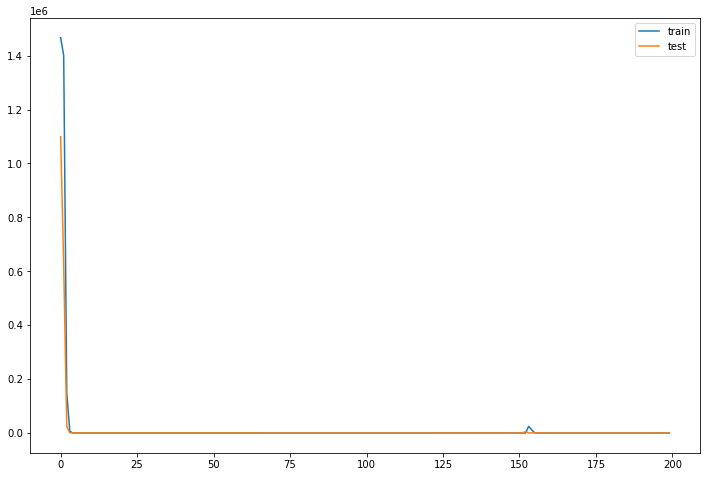

In [193]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(train_loss_avgs, label='train')
ax.plot(test_loss_avgs, label='test')
ax.legend()

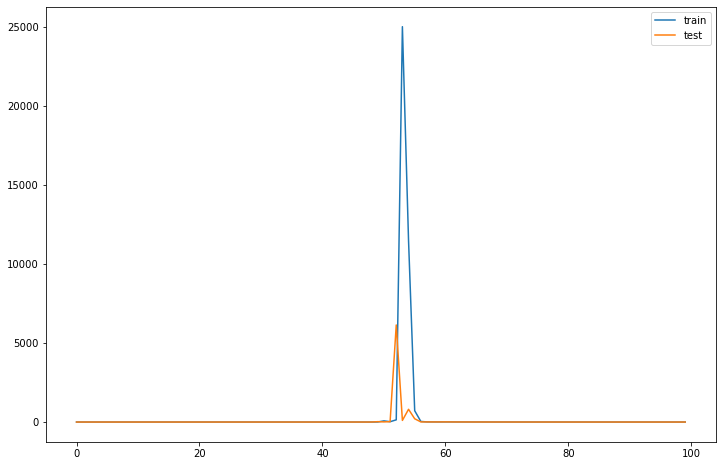

In [194]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(train_loss_avgs[100:], label='train')
ax.plot(test_loss_avgs[100:], label='test')
ax.legend()